In [41]:
import numpy as np
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from omega_gw_jax import OmegaGWjax
# Set matplotlib parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
from nautilus import Sampler
import time
from scipy.special import logsumexp

# Set matplotlib parameters
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)


In [42]:
kmin, kmax = 5e-5, 1e-2
frequencies = jnp.logspace(np.log10(kmin), np.log10(kmax), 50)

fac = 10
p_arr = jnp.geomspace(kmin/fac,kmax*fac,100)

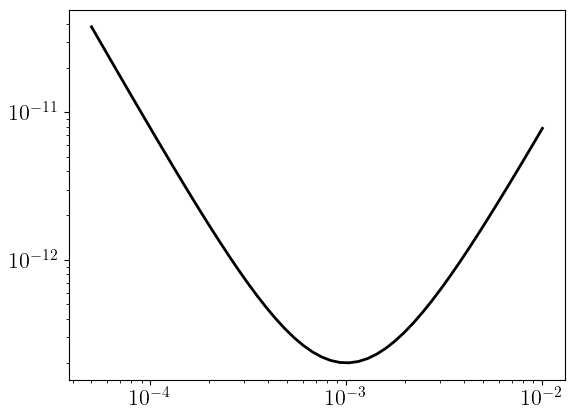

In [43]:
from scipy.stats import norm, truncnorm

def make_truncnorm_95_ul(y_ul):
    """
    Returns a scipy.stats frozen truncnorm distribution over [0, ∞)
    whose 95%-quantile is y_ul.
    """
    # 1) For a standard Normal, the 97.5%-quantile is z_{0.975}
    z975 = norm.ppf(0.975)   # ≈ 1.959963984540054

    # 2) If X ~ TruncNorm(0, ∞; loc=0, scale=sigma), its CDF at y is
    #      F(y) = (Phi(y/sigma) - Phi(0)) / (1 - Phi(0))
    #    But Phi(0)=0.5, so F(y) = 2*Phi(y/sigma) - 1
    #    We want F(y_ul) = 0.95 ⇒ Phi(y_ul/sigma) = 0.975 ⇒ y_ul/sigma = z975
    sigma = y_ul / z975

    # 3) Build the scipy truncnorm “frozen” object.
    #    truncnorm takes arguments (a, b, loc, scale) where a and b are
    #    the lower/upper bounds in *standardized* units.
    a, b = 1e-16 / sigma, np.inf # (0 - 0) / sigma
    return truncnorm(a, b, loc=0.0, scale=sigma)

def noise_model(f,fstar=1e-3,n1=-2,n2=2,sigma=2):
    nir = n1
    pl1 = (f/fstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(f/fstar)**sigma)**nuv
    vals = np.ones_like(f)*5e-13*( 0.01*(np.log(f/fstar))**2 + 0.1)
    # bpl = (f/fstar)**2 * (1+(f/fstar)**(-1))
    return vals * pl1 * pl2

plt.loglog(frequencies, noise_model(frequencies), label='noise', color='black', lw=2)



In [44]:
# Set up internal momenta for the OmegaGWjax calculator.
s = jnp.linspace(0, 1, 15)  # rescaled internal momentum
t = jnp.logspace(-5, 5, 200)  # rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

# Create the gravitational wave background calculator.
gwb_calculator = OmegaGWjax(s=s, t=t, f=frequencies, norm="RD", jit=True)

num_nodes = 4
print(f"Running inference with number of nodes: {num_nodes}, free nodes: {num_nodes - 2}")
free_nodes = num_nodes - 2

# Set the range for the x (log10) nodes using the data.
pk_min, pk_max = min(p_arr), max(p_arr)
left_node = np.log10(pk_min)
right_node = np.log10(pk_max)

# Set the y range for the interpolation.
y_max = 0.
y_min = -8.
y_mins = np.array(num_nodes * [y_min])
y_maxs = np.array(num_nodes * [y_max])

def split_vmap(func,input_arrays,batch_size=8):
    """
    Utility to split vmap over a function taking multiple arrays as input into multiple chunks, useful for reducing memory usage.
    """
    num_inputs = input_arrays[0].shape[0]
    num_batches = (num_inputs + batch_size - 1 ) // batch_size
    batch_idxs = [jnp.arange( i*batch_size, min( (i+1)*batch_size,num_inputs  )) for i in range(num_batches)]
    res = [vmap(func)(*tuple([arr[idx] for arr in input_arrays])) for idx in batch_idxs]
    nres = len(res[0])
    # now combine results across batches and function outputs to return a tuple (num_outputs, num_inputs, ...)
    results = tuple( jnp.concatenate([x[i] for x in res]) for i in range(nres))
    return results

@jit
def prior(cube):
    """
    Transforms the input cube from [0,1] uniform parameters to the desired prior space.
    This vectorized version supports cube being either a 1D array of shape (nd,)
    or a 2D array of shape (Npoints, nd).
    """
    cube = jnp.atleast_2d(cube.copy())
    N = free_nodes  # Number of x parameters
    x = cube[:, :N]
    exponents = 1.0 / jnp.arange(1, N + 1)
    y_vals = x ** exponents  # shape (Npoints, free_nodes)
    t_arr = jnp.cumprod(y_vals[:, ::-1], axis=1)[:, ::-1]
    xs = t_arr * (right_node - left_node) + left_node
    ys = cube[:, N:]
    ys = ys * (y_maxs[None, :] - y_mins[None, :]) + y_mins[None, :]
    return jnp.concatenate([xs, ys], axis=1)

def interpolate(nodes, vals, x):
    res = jnp.power(10, jnp.interp(x, nodes, vals))
    res = jnp.where(x < left_node, 0, res)
    res = jnp.where(x > right_node, 0, res)
    return res

def get_gwb(nodes, vals):
    # Given nodes and values, create a function for Pζ and compute Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    omegagw = gwb_calculator(pf, frequencies)
    return (omegagw,)

# JIT compile get_gwb for speed.
get_gwb_func = jit(get_gwb)

ul_dists = [make_truncnorm_95_ul(noise_model(f)) for f in frequencies]


def likelihood(params):
    params = jnp.atleast_2d(params)
    nodes = params[:, :free_nodes]
    # Pad nodes with fixed endpoints
    nodes = jnp.pad(nodes, ((0, 0), (1, 1)), 'constant',
                      constant_values=((0, 0), (left_node, right_node)))
    vals = params[:, free_nodes:]
    omegagw = split_vmap(get_gwb_func, (nodes, vals), batch_size=200)[0] #(N,Nfreq)
    res = np.zeros_like(omegagw)
    for i in range(len(frequencies)):
        # Compute the log-likelihood for each frequency
        res[:, i] = ul_dists[i].logpdf(omegagw[:, i])
    res = np.sum(res, axis=1)
    return res, omegagw

Running inference with number of nodes: 4, free nodes: 2


In [45]:
ndim = free_nodes + num_nodes
sampler = Sampler(prior, likelihood, ndim, pass_dict=False, vectorized=True,resume=True
                                            ,pool=(None,4),filepath=f'./nautilus_UL_{num_nodes}.h5') 

start = time.time()
sampler.run(verbose=True, f_live=0.001, n_like_max=int(1.5e5))#, n_eff=2000*ndim)
end = time.time()
print('Time taken: {:.2f} s'.format(end - start))
print('log Z: {:.2f}'.format(sampler.log_z))

    # Retrieve posterior samples.
samples, logl, logwt, omegaGW_blob = sampler.posterior(return_blobs=True)
np.savez(f'nautilus_UL_{num_nodes}.npz', samples=samples, logl=logl, logwt=logwt, logz=sampler.log_z)


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 14     | 3        | 4        | 40700    | N/A    | 10040 | +1387.61 
Time taken: 0.00 s
log Z: 1387.61


In [46]:
print(f"shapes: samples {samples.shape}, OmegaGW {omegaGW_blob.shape}")


shapes: samples (41385, 6), OmegaGW (41385, 50)


In [47]:
# plot functional posterior

def weighted_median(data, weights):
    """
    Compute the weighted median of data.
    """
    # Sort the data and weights.
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    # Compute the cumulative sum of the weights.
    cdf = np.cumsum(s_weights)
    # Find the median value.
    idx = np.searchsorted(cdf, 0.5)
    return s_data[idx]

def plot_functional_posterior(vals=[], k_arr=[], intervals=[99.7,95.,68.,],
                              weights = None,
                              ylabels=[r'$P_{\zeta}$', r'$\Omega_{\rm GW}$'],
                              aspect_ratio=(6, 5),
                              interval_cols=[('#006FED', 0.2), ('#006FED', 0.4), ('#006FED', 0.6)]):
    """
    Plot the posterior of y = f(k|x) using symmetric credible intervals.
    """
    nfuncs = len(vals)
    fig, ax = plt.subplots(1, nfuncs, figsize=(aspect_ratio[0] * nfuncs, aspect_ratio[1]), constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    if weights is None:
        weights = np.ones(vals.shape[0])
    for i, val in enumerate(vals):
        # weights_i = weights[i]
        # print(weights_i.shape)
        print(val.shape)
        for j, interval in enumerate(intervals):
            y_high = np.percentile(val, interval, axis=0
                                          ,weights=weights,method='inverted_cdf')
            y_low = np.zeros_like(y_high)
            # print(f"shapes y_high: {y_high.shape}, y_low: {y_low.shape}")
            ax[i].fill_between(k_arr[i], y_low, y_high, color=interval_cols[j][0], alpha=interval_cols[j][1])
        # medians = np.apply_along_axis(weighted_median, 0, val, weights)
        # ax[i].plot(k_arr[i], medians, color='#006FED', lw=2.5)
        # ax[i].plot(k_arr[i], np.median(val, axis=0), color='#006FED', lw=2.5)
        ax[i].set_ylabel(ylabels[i])
    return fig, ax


(20693, 200)
(20693, 50)


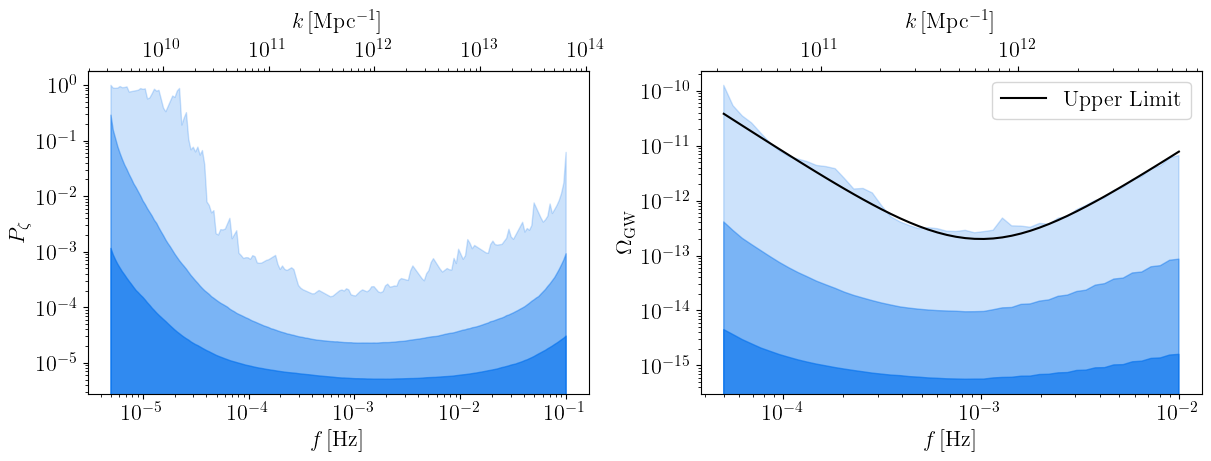

In [48]:
num_samples = 20000
thinning = max(1,len(samples)//num_samples)
xs = samples[:, :free_nodes][::thinning]
ys = samples[:, free_nodes:][::thinning]
xs = jnp.pad(xs, ((0, 0), (1, 1)), 'constant', constant_values=((0, 0), (left_node, right_node)))
ys = jnp.array(ys)
gwb_amps = omegaGW_blob[::thinning]
p_arr_local = jnp.logspace(left_node+0.001, right_node-0.001, 200)
logwt_total = logsumexp(logwt)
weights = np.exp(logwt - logwt_total)
weights = weights / weights.sum()
thinned_weights = weights[::thinning]

def get_pz(nodes, vals):
    # Given nodes and vals, compute Pζ and Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    pz_amps = pf(p_arr_local)
    return (pz_amps,)

pz_amps = split_vmap(get_pz, (xs, ys), batch_size=100)[0]

fig, ax = plot_functional_posterior([pz_amps, gwb_amps],
                                    k_arr=[p_arr_local, frequencies],
                                    intervals = [100,95,68],
                                    weights = thinned_weights,
                                    aspect_ratio=(6,4.5))
# ax[0].loglog(p_arr, pz_amp, color='k', lw=1.5)
Omegas_UL = noise_model(frequencies)
ax[1].loglog(frequencies, Omegas_UL, color='k', lw=1.5, label='Upper Limit')
# ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
plt.savefig(f'nautilus_UL_{num_nodes}.pdf', bbox_inches='tight')


In [49]:
# method 2 for the upper limit distribution

import jax.scipy.stats as stats

y_ul = noise_model(frequencies)
sigmas = 2 * y_ul

def likelihood(params):
    params = jnp.atleast_2d(params)
    nodes = params[:, :free_nodes]
    # Pad nodes with fixed endpoints
    nodes = jnp.pad(nodes, ((0, 0), (1, 1)), 'constant',
                      constant_values=((0, 0), (left_node, right_node)))
    vals = params[:, free_nodes:]
    # shape (batch, Nfreq)
    omegagw = split_vmap(get_gwb_func, (nodes, vals), batch_size=200)[0]

    # Standardized distance *below* the limit for upper‐limits:
    #    z_ul[i] = (y_ul - omegagw) / sigma_obs
    z_ul = (y_ul - omegagw) / sigmas

    # Log‐CDF of the Normal for upper‐limits:
    logcdf_ul = stats.norm.logcdf(z_ul)

    # Combine via the mask:
    #   where is_upper_limit==True, use logcdf_ul
    #   otherwise use logpdf_det
    res = logcdf_ul #jnp.where(is_upper_limit, logcdf_ul, logpdf_det)

    # Sum over frequencies to get a (batch,) array of joint log‐L’s
    total_logl = jnp.sum(res, axis=1)
    return total_logl, omegagw


In [50]:
ndim = free_nodes + num_nodes
sampler = Sampler(prior, likelihood, ndim, pass_dict=False, vectorized=True,resume=True
                                            ,pool=(None,4),filepath=f'./nautilus_UL2_{num_nodes}.h5') 

start = time.time()
sampler.run(verbose=True, f_live=0.001, n_like_max=int(1.5e5))#, n_eff=2000*ndim)
end = time.time()
print('Time taken: {:.2f} s'.format(end - start))
print('log Z: {:.2f}'.format(sampler.log_z))

    # Retrieve posterior samples.
samples, logl, logwt, omegaGW_blob = sampler.posterior(return_blobs=True)
np.savez(f'nautilus_UL2_{num_nodes}.npz', samples=samples, logl=logl, logwt=logwt, logz=sampler.log_z)


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 12     | 2        | 4        | 29900    | N/A    | 10084 | -20.00   
Time taken: 0.00 s
log Z: -20.00


In [51]:
print(f"shapes: samples {samples.shape}, OmegaGW {omegaGW_blob.shape}")

shapes: samples (29900, 6), OmegaGW (29900, 50)


(29900, 200)
(29900, 50)


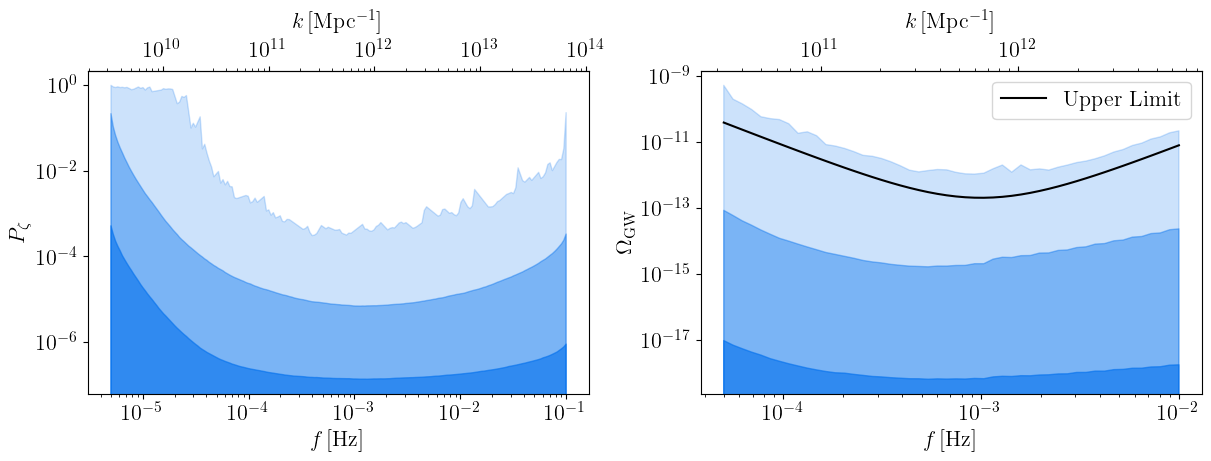

In [52]:
num_samples = 20000
thinning = max(1,len(samples)//num_samples)
xs = samples[:, :free_nodes][::thinning]
ys = samples[:, free_nodes:][::thinning]
xs = jnp.pad(xs, ((0, 0), (1, 1)), 'constant', constant_values=((0, 0), (left_node, right_node)))
ys = jnp.array(ys)
gwb_amps = omegaGW_blob[::thinning]
p_arr_local = jnp.logspace(left_node+0.001, right_node-0.001, 200)
logwt_total = logsumexp(logwt)
weights = np.exp(logwt - logwt_total)
weights = weights / weights.sum()
thinned_weights = weights[::thinning]

def get_pz(nodes, vals):
    # Given nodes and vals, compute Pζ and Ω_GW.
    pf = lambda k: interpolate(nodes, vals, jnp.log10(k))
    pz_amps = pf(p_arr_local)
    return (pz_amps,)

pz_amps = split_vmap(get_pz, (xs, ys), batch_size=100)[0]

fig, ax = plot_functional_posterior([pz_amps, gwb_amps],
                                    k_arr=[p_arr_local, frequencies],
                                    intervals = [100,95,68],
                                    weights = thinned_weights,
                                    aspect_ratio=(6,4.5))
# ax[0].loglog(p_arr, pz_amp, color='k', lw=1.5)
Omegas_UL = noise_model(frequencies)
ax[1].loglog(frequencies, Omegas_UL, color='k', lw=1.5, label='Upper Limit')
# ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
plt.savefig(f'nautilus_UL2_{num_nodes}.pdf', bbox_inches='tight')